In [19]:
import pandas as pd
from pandas import Series, DataFrame
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC,LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB


In [20]:
# get data and label 
train_dataFrame = pd.read_csv("data/train.csv")
test_dataFrame = pd.read_csv("data/test.csv")

# preview the data
train_dataFrame.head()
train_dataFrame.info()
test_dataFrame.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float

In [21]:
# throw the unnecessary data column

train_dataFrame = train_dataFrame.drop(['PassengerId','Name','Ticket'], axis=1)
test_dataFrame  = test_dataFrame.drop(['Name','Ticket'], axis=1)

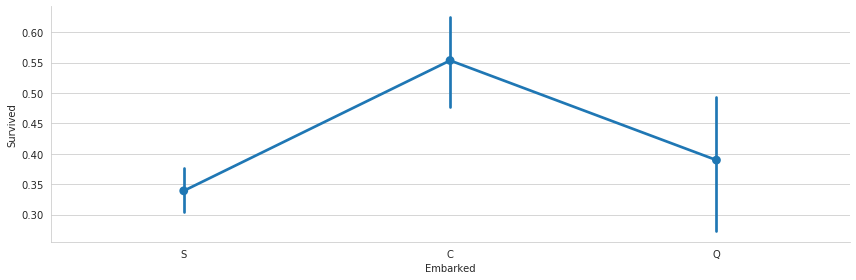

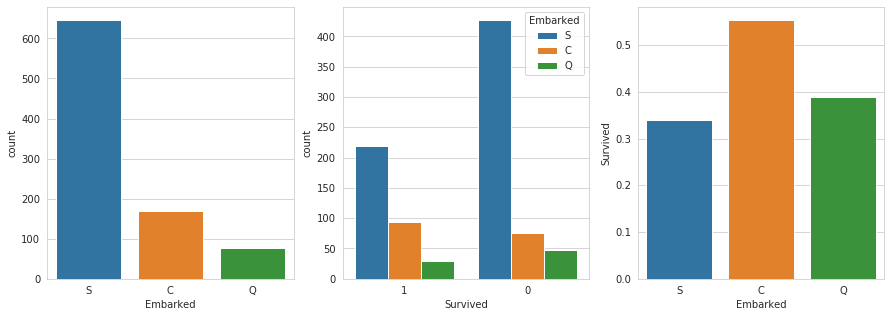

In [22]:
# Embarked
# fill the missing value of the 'Embarked' column
train_dataFrame["Embarked"] = train_dataFrame["Embarked"].fillna("S")

sns.factorplot('Embarked','Survived', data=train_dataFrame,size=4,aspect=3)
fig, (axis1,axis2,axis3) = plt.subplots(1,3,figsize=(15,5))
sns.countplot(x='Embarked', data=train_dataFrame, ax=axis1)
sns.countplot(x='Survived', hue="Embarked", data=train_dataFrame, order=[1,0], ax=axis2)
embark_perc = train_dataFrame[["Embarked", "Survived"]].groupby(['Embarked'],as_index=False).mean()
sns.barplot(x='Embarked', y='Survived', data=embark_perc,order=['S','C','Q'],ax=axis3)

# Throw the "S" dummy variable and rejoin back to the data
embark_dummies_titanic = pd.get_dummies(train_dataFrame['Embarked'])
embark_dummies_titanic.drop(['S'], axis=1, inplace=True)

embark_dummies_test  = pd.get_dummies(test_dataFrame['Embarked'])
embark_dummies_test.drop(['S'], axis=1, inplace=True)

train_dataFrame = train_dataFrame.join(embark_dummies_titanic)
test_dataFrame    = test_dataFrame.join(embark_dummies_test)

train_dataFrame.drop(['Embarked'], axis=1,inplace=True)
test_dataFrame.drop(['Embarked'], axis=1,inplace=True)

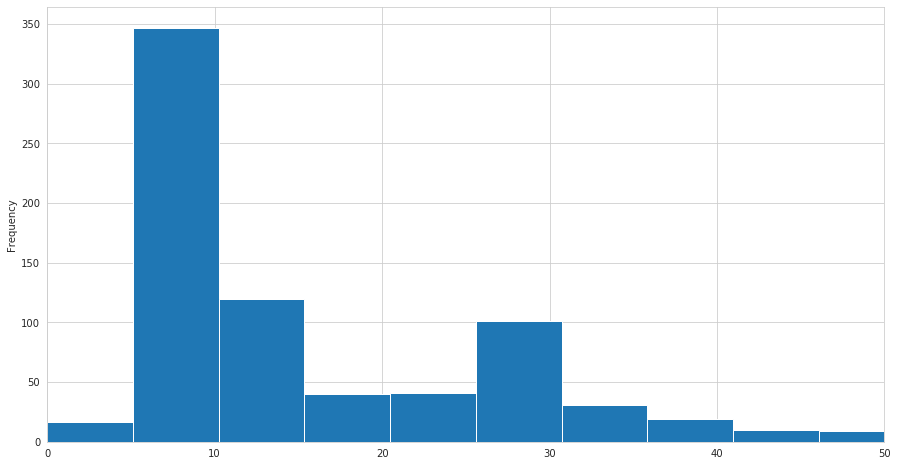

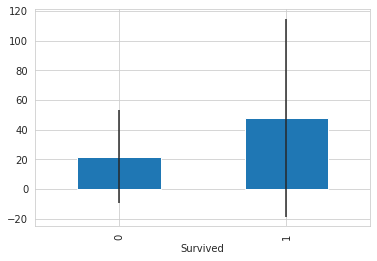

In [23]:
# Fare (ticket price)

# there got a missing value in test_dataFrame only,so fillin with median value
test_dataFrame['Fare'].fillna(test_dataFrame["Fare"].median(), inplace=True)

# convert from float to int
train_dataFrame['Fare'] = train_dataFrame['Fare'].astype(int)
test_dataFrame['Fare']  = test_dataFrame['Fare'].astype(int)

# get fare for survived & didn't survive passengers 
fare_not_survived = train_dataFrame["Fare"][train_dataFrame["Survived"] == 0]
fare_survived     = train_dataFrame["Fare"][train_dataFrame["Survived"] == 1]

# get average and std for fare of survived/not survived passengers
avgerage_fare = DataFrame([fare_not_survived.mean(), fare_survived.mean()])
std_fare      = DataFrame([fare_not_survived.std(), fare_survived.std()])

# plot
train_dataFrame['Fare'].plot(kind='hist', figsize=(15,8),bins=100, xlim=(0,50))

avgerage_fare.index.names = std_fare.index.names = ["Survived"]
avgerage_fare.plot(yerr=std_fare,kind='bar',legend=False)


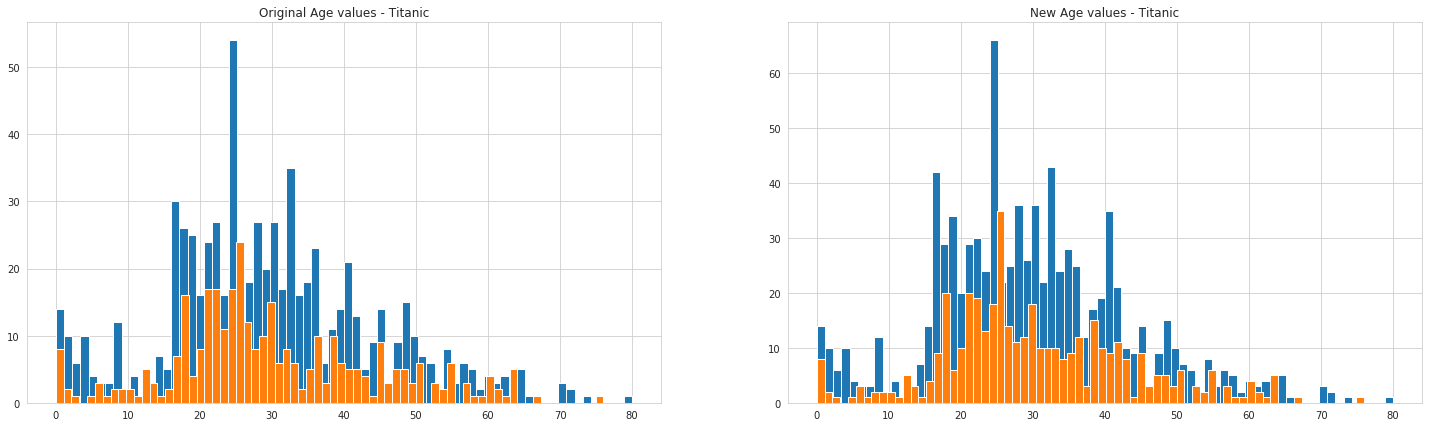

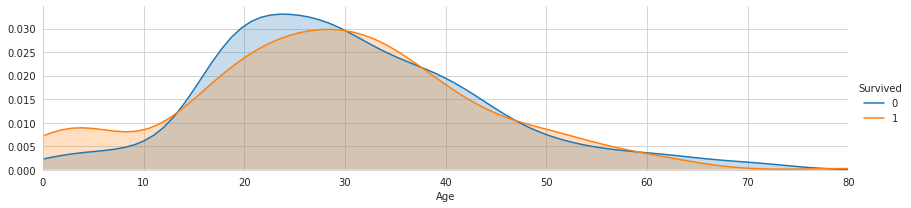

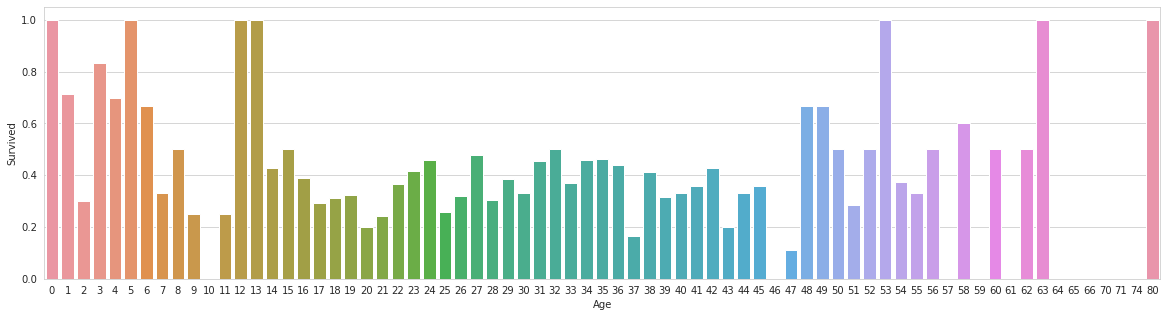

In [24]:
# Age

fig, (axis1,axis2) = plt.subplots(1,2,figsize=(25,7))
axis1.set_title('Original Age values - Titanic')
axis2.set_title('New Age values - Titanic')

# get average, std, Nan values in train_dataFrame(titanic_df)
average_age_titanic = train_dataFrame['Age'].mean()
std_age_titanic = train_dataFrame['Age'].std()
count_nan_age_titanic = train_dataFrame['Age'].isnull().sum()

# get average, std, Nan values in test_dataFrame(test_df)
average_age_test = test_dataFrame['Age'].mean()
std_age_test = test_dataFrame['Age'].std()

count_nan_age_test = test_dataFrame['Age'].isnull().sum()

# generate random numbers between (mean - std) & (mean + std)
rand_1 = np.random.randint(average_age_titanic - std_age_titanic, average_age_titanic + std_age_titanic, size = count_nan_age_titanic)
rand_2 = np.random.randint(average_age_test - std_age_test, average_age_test + std_age_test, size = count_nan_age_test)

# plot original Age values
# NOTE: drop all null values, and convert to int
train_dataFrame['Age'].dropna().astype(int).hist(bins=70, ax=axis1)
test_dataFrame['Age'].dropna().astype(int).hist(bins=70, ax=axis1)

# fill NaN values in Age column with random values generated
train_dataFrame["Age"][np.isnan(train_dataFrame["Age"])] = rand_1
test_dataFrame["Age"][np.isnan(test_dataFrame["Age"])] = rand_2

# convert from float to int
train_dataFrame['Age'] = train_dataFrame['Age'].astype(int)
test_dataFrame['Age']  = test_dataFrame['Age'].astype(int)
        
# plot new Age Values
train_dataFrame['Age'].hist(bins=70, ax=axis2)
test_dataFrame['Age'].hist(bins=70, ax=axis2)

# peaks for survived/not survived passengers by their age
facet = sns.FacetGrid(train_dataFrame, hue="Survived",aspect=4)
facet.map(sns.kdeplot,'Age',shade= True)
facet.set(xlim=(0, train_dataFrame['Age'].max()))
facet.add_legend()

# average survived passengers by age
fig, axis1 = plt.subplots(1,1,figsize=(20,5))
average_age = train_dataFrame[["Age", "Survived"]].groupby(['Age'],as_index=False).mean()
sns.barplot(x='Age', y='Survived', data=average_age)

In [25]:
# Cabin
# It has a lot of NaN values, so it won't cause a remarkable impact on prediction
train_dataFrame.drop("Cabin",axis=1,inplace=True)
test_dataFrame.drop("Cabin",axis=1,inplace=True)

[Text(0, 0, 'With Family'), Text(0, 0, 'Alone')]

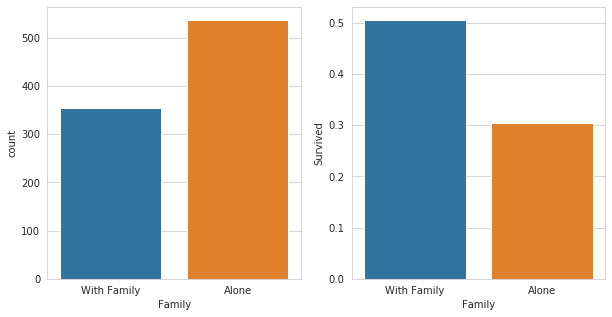

In [26]:
# Family
#for the anyone who got any family member(whether parent, brother, ...) will increase more chance of survive 

train_dataFrame['Family'] = train_dataFrame['Parch'] + train_dataFrame['SibSp']
train_dataFrame['Family'].loc[train_dataFrame['Family'] > 0] = 1
train_dataFrame['Family'].loc[train_dataFrame['Family'] == 0] = 0

test_dataFrame['Family'] = test_dataFrame['Parch'] + test_dataFrame['SibSp']
test_dataFrame['Family'].loc[test_dataFrame['Family'] > 0] = 1
test_dataFrame['Family'].loc[test_dataFrame['Family'] == 0] = 0

# drop Parch & SibSp
train_dataFrame = train_dataFrame.drop(['SibSp','Parch'], axis=1)
test_dataFrame    = test_dataFrame.drop(['SibSp','Parch'], axis=1)

fig, (axis1,axis2) = plt.subplots(1,2,sharex=True,figsize=(10,5))

# sns.factorplot('Family',data=train_dataFrame,kind='count',ax=axis1)
sns.countplot(x='Family', data=train_dataFrame, order=[1,0], ax=axis1)

# average of survived for those who had/didn't have any family member
family_perc = train_dataFrame[["Family", "Survived"]].groupby(['Family'],as_index=False).mean()
sns.barplot(x='Family', y='Survived', data=family_perc, order=[1,0], ax=axis2)

axis1.set_xticklabels(["With Family","Alone"], rotation=0)

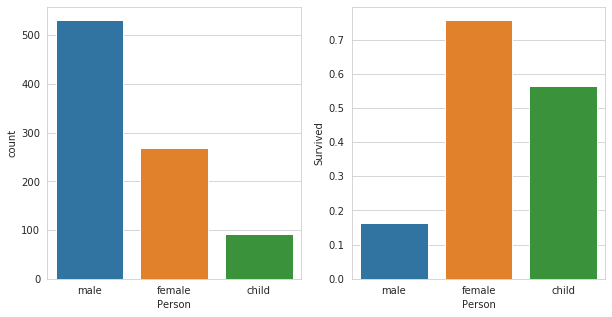

In [27]:
# Sex
# from the data, we can observe that children( age < 16) have a higher chance for survive,so let's classifier passengers as male, female, child

def get_person(passenger):
    age,sex = passenger
    return 'child' if age < 16 else sex
    
train_dataFrame['Person'] = train_dataFrame[['Age','Sex']].apply(get_person,axis=1)
test_dataFrame['Person']  = test_dataFrame[['Age','Sex']].apply(get_person,axis=1)

# No need to use Sex column since we created Person column
train_dataFrame.drop(['Sex'],axis=1,inplace=True)
test_dataFrame.drop(['Sex'],axis=1,inplace=True)

# create dummy variables for Person column, & drop Male as it has the lowest average of survived passengers
person_dummies_titanic  = pd.get_dummies(train_dataFrame['Person'])
person_dummies_titanic.columns = ['Child','Female','Male']
person_dummies_titanic.drop(['Male'], axis=1, inplace=True)

person_dummies_test  = pd.get_dummies(test_dataFrame['Person'])
person_dummies_test.columns = ['Child','Female','Male']
person_dummies_test.drop(['Male'], axis=1, inplace=True)

train_dataFrame = train_dataFrame.join(person_dummies_titanic)
test_dataFrame    = test_dataFrame.join(person_dummies_test)

fig, (axis1,axis2) = plt.subplots(1,2,figsize=(10,5))

# sns.factorplot('Person',data=titanic_df,kind='count',ax=axis1)
sns.countplot(x='Person', data=train_dataFrame, ax=axis1)

# average of survived for each Person(male, female, or child)
person_perc = train_dataFrame[["Person", "Survived"]].groupby(['Person'],as_index=False).mean()
sns.barplot(x='Person', y='Survived', data=person_perc, ax=axis2, order=['male','female','child'])

train_dataFrame.drop(['Person'],axis=1,inplace=True)
test_dataFrame.drop(['Person'],axis=1,inplace=True)


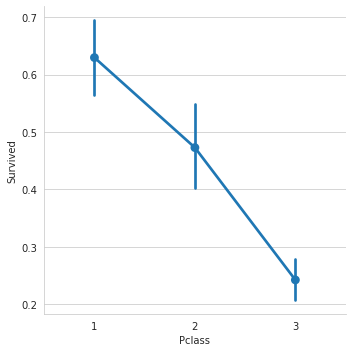

In [28]:
# Pclass

# sns.factorplot('Pclass',data=titanic_df,kind='count',order=[1,2,3])
sns.factorplot('Pclass','Survived',order=[1,2,3], data=train_dataFrame,size=5)

# create dummy variables for Pclass column, & drop 3rd class as it has the lowest average of survived passengers
pclass_dummies_titanic  = pd.get_dummies(train_dataFrame['Pclass'])
pclass_dummies_titanic.columns = ['Class_1','Class_2','Class_3']
pclass_dummies_titanic.drop(['Class_3'], axis=1, inplace=True)

pclass_dummies_test  = pd.get_dummies(test_dataFrame['Pclass'])
pclass_dummies_test.columns = ['Class_1','Class_2','Class_3']
pclass_dummies_test.drop(['Class_3'], axis=1, inplace=True)

train_dataFrame.drop(['Pclass'],axis=1,inplace=True)
test_dataFrame.drop(['Pclass'],axis=1,inplace=True)

train_dataFrame = train_dataFrame.join(pclass_dummies_titanic)
test_dataFrame  = test_dataFrame.join(pclass_dummies_test)


In [29]:
# define training and testing sets

X_train = train_dataFrame.drop("Survived",axis=1)
Y_train = train_dataFrame["Survived"]
X_test  = test_dataFrame.drop("PassengerId",axis=1).copy()

In [30]:
# Logistic Regression

logreg = LogisticRegression()
logreg.fit(X_train, Y_train)
Y_pred_LR = logreg.predict(X_test)
print(logreg.score(X_train, Y_train))


0.8103254769921436


In [31]:
# Support Vector Machines

svc = SVC()
svc.fit(X_train, Y_train)
Y_pred_SVC = svc.predict(X_test)
print(svc.score(X_train, Y_train))

0.6812570145903479


In [32]:
# Random Forests

random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train, Y_train)
Y_pred_RFC = random_forest.predict(X_test)
print(random_forest.score(X_train, Y_train))

0.9618406285072951


In [33]:
# KNN

knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(X_train, Y_train)
Y_pred_KNN = knn.predict(X_test)
print(knn.score(X_train, Y_train))

0.8181818181818182


In [34]:
# Gaussian Naive Bayes

gaussian = GaussianNB()
gaussian.fit(X_train, Y_train)
Y_pred_GNB = gaussian.predict(X_test)
print(gaussian.score(X_train, Y_train))

0.7609427609427609


In [35]:
# get Correlation Coefficient for each feature using Logistic Regression
coeff_df = DataFrame(train_dataFrame.columns.delete(0))
coeff_df.columns = ['Features']
coeff_df["Coefficient Estimate"] = pd.Series(logreg.coef_[0])

# preview
print(coeff_df)

Features  Coefficient Estimate
0      Age             -0.020949
1     Fare              0.000912
2        C              0.646171
3        Q              0.322792
4   Family             -0.178818
5    Child              1.798064
6   Female              2.777417
7  Class_1              2.004734
8  Class_2              1.134357


In [36]:
# Conclusion to csv file
submission = pd.DataFrame({
        "PassengerId": test_dataFrame["PassengerId"],
        "Survived": Y_pred_RFC
    })
submission.to_csv('titanic.csv', index=False)